In [1]:
from google.colab import drive
import os 
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
base_dir = '/content/drive/My Drive/NewModel_Bangkit2023'
!ls "/content/drive/My Drive/NewModel_Bangkit2023"

Bahan  Train  Validation


In [15]:
#Menentukan Direktori
bahan_dir = os.path.join(base_dir, 'Bahan/')
train_dir = os.path.join(base_dir, 'Train/')
validation_dir = os.path.join(base_dir, 'Validation/')

In [16]:
#Menentukan direktori isi bahan
ayam_dir = os.path.join(bahan_dir, 'Ayam')

In [17]:
#Menetukan Direktori Isi file 'Bahan'
print("Jumlah Data Sampel Ayam")
print("Jumlah ayam : ", len(os.listdir(ayam_dir)))

Jumlah Data Sampel Ayam
Jumlah ayam :  190


In [18]:
#Menetukan Direktori Isi file 'Train'
train_ayam = os.path.join(train_dir, 'Ayam/')

#Menetukan Direktori Isi file 'Validation'
validation_ayam = os.path.join(validation_dir, 'Ayam/')


### **Menyiapkan Dataset**

In [20]:
import random
import shutil

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    shutil.copytree(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    shutil.copytree(i_file, destination)

#Jumlah Pembagian Data Training dan Testing
train_ratio = 0.9

#Pembagian Training dan Validasi
#Training & Validation
source_0 = bahan_dir
train_0 = train_ayam
val_0 = validation_ayam
train_val_split(source_0, train_0, val_0, train_ratio)

In [8]:
print("Jumlah All Ayam  : ", len(os.listdir(ayam_dir)))
print("Jumlah Train Ayam  : ", len(os.listdir(train_ayam)))
print("Jumlah Val Ayam  : ", len(os.listdir(validation_ayam)))

Jumlah All Ayam  :  190
Jumlah Train Ayam  :  180
Jumlah Val Ayam  :  1


# **Pre Processing**

In [21]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
train_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
              rescale = 1./255,
              rotation_range = 30,
              horizontal_flip = True,
              shear_range = 0.3,
              fill_mode = 'nearest',
              width_shift_range = 0.2,
              height_shift_range = 0.2,
              zoom_range = 0.1
)

## **Target**

In [23]:
train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (150, 150),
                  batch_size = 10,
                  class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
                validation_dir,
                target_size = (150, 150),
                batch_size = 10,
                class_mode = 'categorical'
)

Found 179 images belonging to 1 classes.
Found 189 images belonging to 1 classes.


In [24]:
from keras import callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if(logs.get('accuracy') > 0.8):
      print('\nAkurasi mencapai 80%')
      self.model.stop_training = True

callbacks = myCallback()

In [25]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dropout(0.3, seed=112),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dropout(0.5, seed=112),
        tf.keras.layers.Dense(2, activation = 'sigmoid')
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [27]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [28]:
history = model.fit(
          train_generator,
          steps_per_epoch = 9,
          epochs = 25,
          validation_data = val_generator,
          validation_steps = 1,
          verbose = 1,
          callbacks = [callbacks]
)

Epoch 1/25
9/9 [==============================] - 41s 4s/step - loss: 6.6784 - accuracy: 0.5111 - val_loss: 22.7472 - val_accuracy: 0.0000e+00
Epoch 2/25
9/9 [==============================] - 18s 2s/step - loss: 158.4108 - accuracy: 0.4944 - val_loss: 11.1982 - val_accuracy: 0.0000e+00
Epoch 3/25
9/9 [==============================] - 9s 1s/step - loss: 1602.4191 - accuracy: 0.4889 - val_loss: 921.7321 - val_accuracy: 1.0000
Epoch 4/25
9/9 [==============================] - 4s 516ms/step - loss: 10787.1787 - accuracy: 0.5843 - val_loss: 6156.4561 - val_accuracy: 0.0000e+00
Epoch 5/25
9/9 [==============================] - 5s 520ms/step - loss: 58553.1445 - accuracy: 0.4889 - val_loss: 38790.6484 - val_accuracy: 0.0000e+00
Epoch 6/25
9/9 [==============================] - 3s 290ms/step - loss: 240234.7812 - accuracy: 0.3708 - val_loss: 62140.0508 - val_accuracy: 1.0000
Epoch 7/25
9/9 [==============================] - 2s 266ms/step - loss: 861729.8750 - accuracy: 0.5506 - val_loss: 752

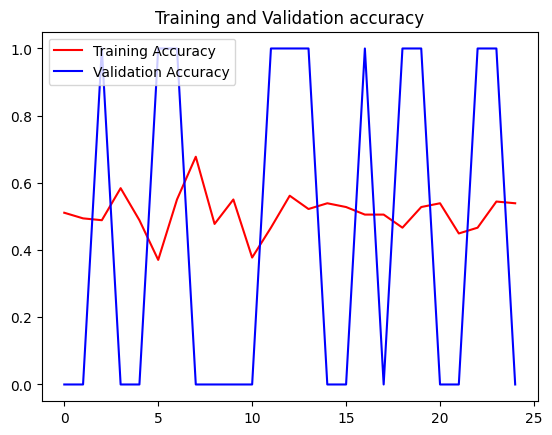

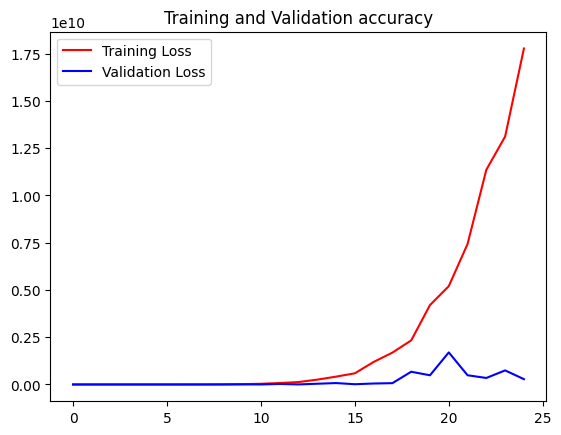

In [29]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

Saving Image_1.jpg to Image_1 (2).jpg
1/1 [==============================] - 0s 22ms/step
Image_1.jpg
This image belongs to class Ayam


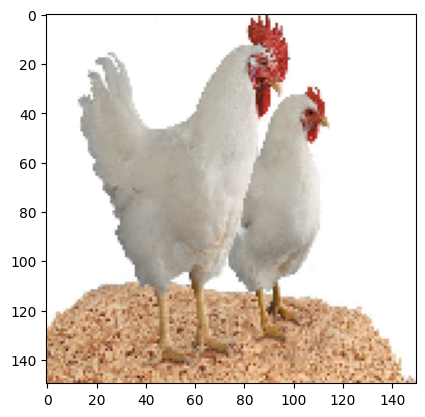

In [35]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  #Prediksi Gambar
  path = fn
  img = image.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(train_dir)

  for j in range(42):
    if classes[0][j] == 1. :
      print('This image belongs to class', class_list[j-1])
      break